# **CS224W - Colab 1**

In this Colab, we will write a full pipeline for **learning node embeddings**.
We will go through the following 3 steps.

To start, we will load a classic graph in network science, the [Karate Club Network](https://en.wikipedia.org/wiki/Zachary%27s_karate_club). We will explore multiple graph statistics for that graph.

We will then work together to transform the graph structure into a PyTorch tensor, so that we can perform machine learning over the graph.

Finally, we will finish the first learning algorithm on graphs: a node embedding model. For simplicity, our model here is simpler than DeepWalk / node2vec algorithms taught in the lecture. But it's still rewarding and challenging, as we will write it from scratch via PyTorch.

Now let's get started! This Colab should take 1-2 hours to complete.

**Note**: Make sure to **restart and run all** before submission, so that the intermediate variables / packages will carry over to the next cell

# 1 Graph Basics
To start, we will load a classic graph in network science, the [Karate Club Network](https://en.wikipedia.org/wiki/Zachary%27s_karate_club). We will explore multiple graph statistics for that graph.

## Setup
We will heavily use NetworkX in this Colab.

In [1]:
import networkx as nx

## Zachary's karate club network

The [Karate Club Network](https://en.wikipedia.org/wiki/Zachary%27s_karate_club) is a graph which describes a social network of 34 members of a karate club and documents links between members who interacted outside the club.

In [2]:
G = nx.karate_club_graph()

# G is an undirected graph
type(G)

networkx.classes.graph.Graph

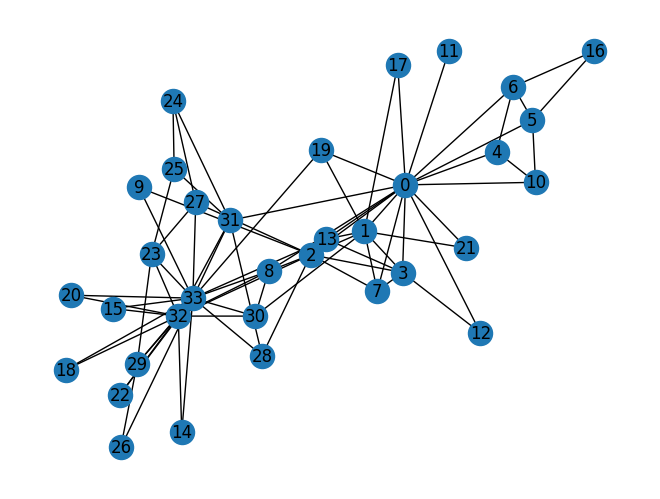

In [3]:
# Visualize the graph
nx.draw(G, with_labels = True)

## Question 1: What is the average degree of the karate club network? (5 Points)

In [5]:
def average_degree(num_edges, num_nodes):
    '''平均度'''
    avg_degree = round(2 * num_edges / num_nodes)

    return avg_degree

num_edges = G.number_of_edges()
num_nodes = G.number_of_nodes()
avg_degree = average_degree(num_edges, num_nodes)
print("Average degree of karate club network is {}".format(avg_degree))

Average degree of karate club network is 5


## Question 2: What is the average clustering coefficient of the karate club network? (5 Points)

In [6]:
def average_clustering_coefficient(G):
    '''平均聚类系数'''
    avg_cluster_coef = nx.average_clustering(G)
    avg_cluster_coef = round(avg_cluster_coef, 2)
    
    return avg_cluster_coef

avg_cluster_coef = average_clustering_coefficient(G)
print("Average clustering coefficient of karate club network is {}".format(avg_cluster_coef))

Average clustering coefficient of karate club network is 0.57


## Question 3: What is the PageRank value for node 0 (node with id 0) after one PageRank iteration? (5 Points)

Page Rank measures importance of nodes in a graph using the link structure of the web. A “vote” from an important page is worth more. Specifically, if  a page $i$ with importance $r_i$ has $d_i$ out-links, then each link gets $\frac{r_i}{d_i}$ votes. Thus, the importance of a Page $j$, represented as $r_j$ is the sum of the votes on its in links.
$$r_j = \sum_{i \rightarrow j} \frac{r_i}{d_i}$$, where $d_i$ is the out degree of node $i$.

The PageRank algorithm (used by Google) outputs a probability distribution which represent the likelihood of a random surfer clicking on links will arrive at any particular page. At each time step, the random surfer has two options
- With prob. $\beta$, follow a link at random
- With prob. $1- \beta$, jump to a random page

Thus, the importance of a particular page is calculated with the following PageRank equation:
 $$r_j = \sum_{i \rightarrow j} \beta \frac{r_i}{d_i} + (1 - \beta) \frac{1}{N}$$

Please complete the code block by implementing the above PageRank equation for node 0.

Note - You can refer to more information from the slides here - http://snap.stanford.edu/class/cs224w-2020/slides/04-pagerank.pdf




In [7]:
def one_iter_pagerank(G, beta, r0, node_id):
    '''一次迭代后的PageRank'''
    ## Note:
    ## 1: You should not use nx.pagerank
    
    r1 = 0
    N = G.number_of_nodes()
    
    # 遍历邻居
    for nbr in G.neighbors(node_id):
        d_i = G.degree(nbr)
        r1 += beta * (r0 / d_i)
    
    # 添加随机跳转部分
    r1 += (1 - beta) * (1 / N)
    r1 = round(r1, 2)

    return r1

beta = 0.8
r0 = 1 / G.number_of_nodes()
node = 0
r1 = one_iter_pagerank(G, beta, r0, node)
print("The PageRank value for node 0 after one iteration is {}".format(r1))

The PageRank value for node 0 after one iteration is 0.13


## Question 4: What is the (raw) closeness centrality for the karate club network node 5? (5 Points)

The equation for closeness centrality is $c(v) = \frac{1}{\sum_{u \neq v}\text{shortest path length between } u \text{ and } v}$

In [8]:
def closeness_centrality(G, node=5):
    '''中心性'''
    # closeness = nx.closeness_centrality(G, node)
    
    N = len(G.nodes())
    
    # 计算 node 到其他节点的最短路径长度
    shortest_paths = nx.shortest_path_length(G, source=node)
    lengths = [length for target, length in shortest_paths.items() if target != node]
    total = sum(lengths)
    
    # 若总路径长度为 0 则该节点无法到达其他节点，中心性为 0
    if total > 0:
        closeness = (N-1) / total
    else:
        closeness = 0
    closeness = round(closeness, 2)

    return closeness

node = 5
closeness = closeness_centrality(G, node=node)
print("The node 5 has closeness centrality {}".format(closeness))

The node 5 has closeness centrality 0.38


# 2 Graph to Tensor
We will then work together to transform the graph $G$ into a PyTorch tensor, so that we can perform machine learning over the graph.

## Setup
Check if PyTorch is properly installed

In [9]:
import torch
print(torch.__version__)

2.4.1


## PyTorch tensor basics

We can generate PyTorch tensor with all zeros, ones or random values.

In [10]:
# Generate 3 x 4 tensor with all ones
ones = torch.ones(3, 4)
print(ones)

# Generate 3 x 4 tensor with all zeros
zeros = torch.zeros(3, 4)
print(zeros)

# Generate 3 x 4 tensor with random values on the interval [0, 1)
random_tensor = torch.rand(3, 4)
print(random_tensor)

# Get the shape of the tensor
print(ones.shape)

tensor([[1., 1., 1., 1.],
        [1., 1., 1., 1.],
        [1., 1., 1., 1.]])
tensor([[0., 0., 0., 0.],
        [0., 0., 0., 0.],
        [0., 0., 0., 0.]])
tensor([[0.5627, 0.2231, 0.4255, 0.7039],
        [0.0281, 0.1933, 0.5920, 0.9510],
        [0.0953, 0.9217, 0.0193, 0.3396]])
torch.Size([3, 4])


PyTorch tensor contains elements for a single data type, the `dtype`.

In [11]:
# Create a 3 x 4 tensor with all 32-bit floating point zeros
zeros = torch.zeros(3, 4, dtype=torch.float32)
print(zeros.dtype)

# Change the tensor dtype to 64-bit integer
zeros = zeros.type(torch.long)
print(zeros.dtype)

torch.float32
torch.int64


## Question 5: Get the edge list of the karate club network and transform it into `torch.LongTensor`. What is the `torch.sum` value of `pos_edge_index` tensor? (10 Points)

In [12]:
def graph_to_edge_list(G):
    '''获取图的所有边，列表形式'''

    edge_list = list(G.edges())

    return edge_list

def edge_list_to_tensor(edge_list):
    '''边转为 tensor'''
    # 读取，转置
    edge_index = torch.tensor(edge_list, dtype=torch.long).t()
    
    return edge_index

pos_edge_list = graph_to_edge_list(G)
pos_edge_index = edge_list_to_tensor(pos_edge_list)
print("The pos_edge_index tensor has shape {}".format(pos_edge_index.shape))
print("The pos_edge_index tensor has sum value {}".format(torch.sum(pos_edge_index)))

The pos_edge_index tensor has shape torch.Size([2, 78])
The pos_edge_index tensor has sum value 2535


## Question 6: Please implement following function that samples negative edges. Then answer which edges (edge_1 to edge_5) are the negative edges in the karate club network? (10 Points)

"Negative" edges refer to the edges/links that do not exist in the graph. The term "negative" is borrowed from "negative sampling" in link prediction. It has nothing to do with the edge weights.

For example, given an edge (src, dst), you should check that neither (src, dst) nor (dst, src) are edges in the Graph. If these hold true, then it is a negative edge.

In [13]:
import random

def sample_negative_edges(G, num_neg_samples):
    '''边的负采样'''
    neg_edge_list = []
    nodes = list(G.nodes())
    existing_edges = set(G.edges())
    
    # 开始采样负边
    while len(neg_edge_list) < num_neg_samples:
        u = random.choice(nodes)
        v = random.choice(nodes)
        # 自环不被考虑
        if u != v and (u,v) not in existing_edges and (v,u) not in existing_edges:
            neg_edge_list.append((u,v))

    return neg_edge_list

# Sample 78 negative edges
neg_edge_list = sample_negative_edges(G, len(pos_edge_list))

# Transform the negative edge list to tensor
neg_edge_index = edge_list_to_tensor(neg_edge_list)
print("The neg_edge_index tensor has shape {}".format(neg_edge_index.shape))

# Which of following edges can be negative ones?
edge_1 = (7, 1)
edge_2 = (1, 33)
edge_3 = (33, 22)
edge_4 = (0, 4)
edge_5 = (4, 2)

def can_be_negative(G, edge):
    '''判断负边'''
    is_negative = False
    # 判断
    if edge[0] != edge[1] and edge not in G.edges() and edge not in G.edges():
        is_negative = True
    
    return is_negative

print(f"Edge 1 can be a negative edge: {can_be_negative(G, edge_1)}")
print(f"Edge 2 can be a negative edge: {can_be_negative(G, edge_2)}")
print(f"Edge 3 can be a negative edge: {can_be_negative(G, edge_3)}")
print(f"Edge 4 can be a negative edge: {can_be_negative(G, edge_4)}")
print(f"Edge 5 can be a negative edge: {can_be_negative(G, edge_5)}")

The neg_edge_index tensor has shape torch.Size([2, 78])
Edge 1 can be a negative edge: False
Edge 2 can be a negative edge: True
Edge 3 can be a negative edge: False
Edge 4 can be a negative edge: False
Edge 5 can be a negative edge: True


# 3 Node Emebedding Learning

Finally, we will finish the first learning algorithm on graphs: a node embedding model.


## Setup

In [14]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

print(torch.__version__)

2.4.1


To write our own node embedding learning methods, we'll heavily use the [`nn.Embedding`](https://pytorch.org/docs/stable/generated/torch.nn.Embedding.html) module in PyTorch. Let's see how to use `nn.Embedding`:

In [15]:
# Initialize an embedding layer
# Suppose we want to have embedding for 4 items (e.g., nodes)
# Each item is represented with 8 dimensional vector

emb_sample = nn.Embedding(num_embeddings=4, embedding_dim=8)
print('Sample embedding layer: {}'.format(emb_sample))

Sample embedding layer: Embedding(4, 8)


We can select items from the embedding matrix, by using Tensor indices

In [16]:
# Select an embedding in emb_sample
id = torch.LongTensor([1])
print(emb_sample(id))

# Select multiple embeddings
ids = torch.LongTensor([1, 3])
print(emb_sample(ids))

# Get the shape of the embedding weight matrix
shape = emb_sample.weight.data.shape
print(shape)

# Overwrite the weight to tensor with all ones
emb_sample.weight.data = torch.ones(shape)

# Let's check if the emb is indeed initilized
ids = torch.LongTensor([0, 3])
print(emb_sample(ids))

tensor([[ 0.0643, -0.6521,  0.1235,  0.0435,  0.7306, -0.9286, -0.2463,  0.4538]],
       grad_fn=<EmbeddingBackward0>)
tensor([[ 0.0643, -0.6521,  0.1235,  0.0435,  0.7306, -0.9286, -0.2463,  0.4538],
        [ 0.0295,  3.1822,  2.7626,  0.3644,  0.8467, -0.4309, -1.1269,  0.5526]],
       grad_fn=<EmbeddingBackward0>)
torch.Size([4, 8])
tensor([[1., 1., 1., 1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1., 1., 1., 1.]], grad_fn=<EmbeddingBackward0>)


Now, it's your time to create node embedding matrix for the graph we have!
- We want to have **16 dimensional** vector for each node in the karate club network.
- We want to initalize the matrix under **uniform distribution**, in the range of $[0, 1)$. We suggest you using [`torch.rand`](https://pytorch.org/docs/stable/generated/torch.rand.html).

In [17]:
# Please do not change / reset the random seed
torch.manual_seed(1)

def create_node_emb(num_node=34, embedding_dim=16):
    '''创建节点嵌入矩阵'''
    # 创建嵌入层
    emb = nn.Embedding(num_embeddings=num_node, embedding_dim=embedding_dim)
    # 使用均匀分布初始化权重
    nn.init.uniform_(emb.weight, -1, 1)

    return emb

emb = create_node_emb()
ids = torch.LongTensor([0, 3])

# Print the embedding layer
print("Embedding: {}".format(emb))

# An example that gets the embeddings for node 0 and 3
print(emb(ids))

Embedding: Embedding(34, 16)
tensor([[-0.5773,  0.4670, -0.7134,  0.9294, -0.4133,  0.5903,  0.0341, -0.4398,
          0.6678, -0.7630, -0.5291,  0.1199,  0.7933, -0.4285, -0.6089, -0.6384],
        [ 0.4972,  0.3093, -0.2314,  0.9640,  0.2024, -0.2580, -0.0142,  0.9830,
          0.6717, -0.0741,  0.9804,  0.4391, -0.5324, -0.9101,  0.5811,  0.9378]],
       grad_fn=<EmbeddingBackward0>)


## Visualize the initial node embeddings
One good way to understand an embedding matrix, is to visualize it in a 2D space.
Here, we have implemented an embedding visualization function for you.
We first do PCA to reduce the dimensionality of embeddings to a 2D space.
Then we visualize each point, colored by the community it belongs to.

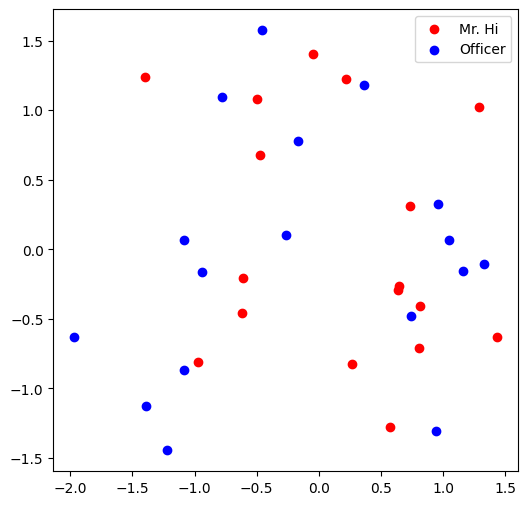

In [18]:
def visualize_emb(emb):
    X = emb.weight.data.numpy()
    pca = PCA(n_components=2)
    components = pca.fit_transform(X)
    plt.figure(figsize=(6, 6))
    club1_x = []
    club1_y = []
    club2_x = []
    club2_y = []
    for node in G.nodes(data=True):
        if node[1]['club'] == 'Mr. Hi':
            club1_x.append(components[node[0]][0])
            club1_y.append(components[node[0]][1])
        else:
            club2_x.append(components[node[0]][0])
            club2_y.append(components[node[0]][1])
    plt.scatter(club1_x, club1_y, color="red", label="Mr. Hi")
    plt.scatter(club2_x, club2_y, color="blue", label="Officer")
    plt.legend()
    plt.show()

# Visualize the initial random embeddding
visualize_emb(emb)

## Question 7: Training the embedding! What is the best performance you can get? (20 Points)

We want to optimize our embeddings for the task of classifying edges as positive or negative. Given an edge and the embeddings for each node, the dot product of the embeddings, followed by a sigmoid, should give us the likelihood of that edge being either positive (output of sigmoid > 0.5) or negative (output of sigmoid < 0.5).

Note that we're using the functions you wrote in the previous questions, _as well as the variables initialized in previous cells_. If you're running into issues, make sure your answers to questions 1-6 are correct.

In [19]:
from torch.optim import SGD
import torch.nn as nn

def accuracy(pred, label):
    '''计算准确率'''
    # 将预测值转为 0 或 1
    pred_label = (pred > 0.5).float()
    
    # 计算准确率
    correcr = (pred_label == label).float().sum()
    accu = correcr / label.shape[0]
    accu = round(accu.item(), 4)
    
    return accu

def train(emb, loss_fn, train_label, train_edge):
    '''训练函数'''
    # TODO: Train the embedding layer here. You can also change epochs and
    # learning rate. In general, you need to implement:
    # (1) Get the embeddings of the nodes in train_edge
    # (2) Dot product the embeddings between each node pair
    # (3) Feed the dot product result into sigmoid
    # (4) Feed the sigmoid output into the loss_fn
    # (5) Print both loss and accuracy of each epoch
    # (6) Update the embeddings using the loss and optimizer
    # (as a sanity check, the loss should decrease during training)

    epochs = 500
    learning_rate = 0.1

    optimizer = SGD(emb.parameters(), lr=learning_rate, momentum=0.9)

    for epoch in range(epochs):
        # 获取训练边中节点对的嵌入
        u_emb = emb(train_edge[0])
        v_emb = emb(train_edge[1])
        
        # 计算点积（节点对的相似度）再 sigmoid
        dot_product = (u_emb * v_emb).sum(dim=1)
        pred = torch.sigmoid(dot_product)
        
        # 计算损失、准确率
        loss = loss_fn(pred, train_label)
        accu = accuracy(pred, train_label)
        if epoch % 50 == 0:
            print(f'Epoch {epoch}: Loss = {loss.item()}, Accuracy = {accu}')
        
        # 优化：梯度清零，反向传播计算梯度，更新嵌入
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
    return emb

loss_fn = nn.BCELoss()

print(pos_edge_index.shape)

# Generate the positive and negative labels
pos_label = torch.ones(pos_edge_index.shape[1], )
neg_label = torch.zeros(neg_edge_index.shape[1], )

# Concat positive and negative labels into one tensor
train_label = torch.cat([pos_label, neg_label], dim=0)

# Concat positive and negative edges into one tensor
# Since the network is very small, we do not split the edges into val/test sets
train_edge = torch.cat([pos_edge_index, neg_edge_index], dim=1)
print(train_edge.shape)

train(emb, loss_fn, train_label, train_edge)

torch.Size([2, 78])
torch.Size([2, 156])
Epoch 0: Loss = 0.9025148153305054, Accuracy = 0.5
Epoch 50: Loss = 0.3298068046569824, Accuracy = 0.9167
Epoch 100: Loss = 0.1502346247434616, Accuracy = 1.0
Epoch 150: Loss = 0.08421747386455536, Accuracy = 1.0
Epoch 200: Loss = 0.05426323041319847, Accuracy = 1.0
Epoch 250: Loss = 0.03854725509881973, Accuracy = 1.0
Epoch 300: Loss = 0.029253864660859108, Accuracy = 1.0
Epoch 350: Loss = 0.02324979566037655, Accuracy = 1.0
Epoch 400: Loss = 0.019109662622213364, Accuracy = 1.0
Epoch 450: Loss = 0.016110926866531372, Accuracy = 1.0


Embedding(34, 16)

## Visualize the final node embeddings
Visualize your final embedding here!
You can visually compare the figure with the previous embedding figure.
After training, you should oberserve that the two classes are more evidently separated.
This is a great sanitity check for your implementation as well.

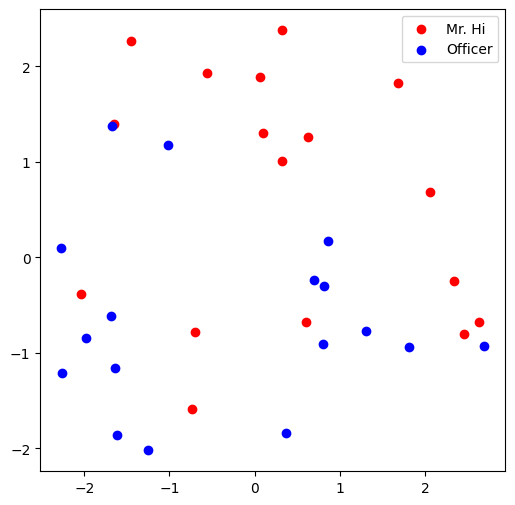

In [20]:
# Visualize the final learned embedding
visualize_emb(emb)

# Submission

When you submit your assignment, you will have to download this file as an `.ipynb` file. Please name this file `CS224W_Colab_1.ipynb`. Make sure that the files are name correctly, otherwise the autograder will not be able to find your submission files.